In [61]:
from openfermion import QubitOperator
import cirq
import numpy as np 

In [29]:
H = QubitOperator()

H+= QubitOperator('X0 Z1 Z2', 0.1)
H+= QubitOperator('X0 X2', 0.3)
H+= QubitOperator('Z0 Z1', 0.1)

H

0.1 [X0 Z1 Z2] +
0.3 [X0 X2] +
0.1 [Z0 Z1]

In [76]:
qubits = list(cirq.LineQubit.range(3))
ansatz_circuit = cirq.Circuit(
*[cirq.I.on(qubits[0]), cirq.H.on(qubits[1]), cirq.I.on(qubits[2])]
)
ansatz_circuit

0: ───I───

1: ───H───

2: ───I───

In [253]:
measure_ZZI_statevector = ansatz_circuit.final_state_vector()
measure_ZZI_statevector

array([ 0.70710678+0.j,  0.        +0.j,  0.70710678+0.j, -0.        +0.j,
        0.        +0.j,  0.        +0.j, -0.        +0.j, -0.        +0.j])

In [78]:
measure_XZZ_circuit = ansatz_circuit.copy()

measure_XZZ_circuit.append([cirq.H.on(qubits[0])])
measure_XZZ_circuit

0: ───I───H───

1: ───H───────

2: ───I───────

In [79]:
measure_XZZ_statevector = measure_XZZ_circuit.final_state_vector()
measure_XZZ_statevector

array([ 0.5+0.j,  0. +0.j,  0.5+0.j,  0. +0.j,  0.5+0.j, -0. +0.j,
        0.5+0.j, -0. +0.j])

In [38]:
measure_XIX_circuit = ansatz_circuit.copy()

measure_XIX_circuit.append([cirq.H.on(qubits[0]), cirq.H.on(qubits[2])])
measure_XIX_circuit

0: ───I───H───

1: ───H───────

2: ───I───H───

In [39]:
measure_XIX_statevector = measure_XIX_circuit.final_state_vector()
measure_XIX_statevector

array([0.35355339+0.j, 0.35355339+0.j, 0.35355339+0.j, 0.35355339+0.j,
       0.35355339+0.j, 0.35355339+0.j, 0.35355339+0.j, 0.35355339+0.j])

In [176]:
N_shots=int(1e6)

In [177]:
XZZ_measurements = cirq.sim.sample_state_vector(
    state_vector= measure_XZZ_statevector,
    indices=[0, 1, 2],
    repetitions=N_shots
    )

In [178]:
XIX_measurements = cirq.sim.sample_state_vector(
    state_vector= measure_XIX_statevector,
    indices=[0,2],
    repetitions=N_shots
    )

In [179]:
ZZI_measurements = cirq.sim.sample_state_vector(
    state_vector= measure_ZZI_statevector,
    indices=[0,1],
    repetitions=N_shots
    )
ZZI_measurements

array([[0, 1],
       [0, 0],
       [0, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 0]], dtype=uint8)

In [180]:
H_list = list(H)
H_list

[0.1 [X0 Z1 Z2], 0.3 [X0 X2], 0.1 [Z0 Z1]]

In [181]:
combined_measurements = [XZZ_measurements, XIX_measurements, ZZI_measurements]

parity_results =[]
for res in combined_measurements:
    sum_rows = np.sum(res, axis=1)%2
    parity_results.append(sum_rows)
H_list

[0.1 [X0 Z1 Z2], 0.3 [X0 X2], 0.1 [Z0 Z1]]

In [182]:
H_exp_results=[]
for res_ind in range(N_shots):
    H_exp_val=0
    for ind, Pword in enumerate(H_list):
        P_word, coeff = tuple(*Pword.terms.items())
        
        parity_instance = parity_results[ind][res_ind]
        if parity_instance==0:
            H_exp_val+=coeff*+1
        else:
            H_exp_val+=coeff*-1
    H_exp_results.append(H_exp_val)
            

In [200]:
from collections import Counter

result_counted = Counter(H_exp_results)

## numerical accuracy means some terms are the same but not added!
result_counted       

Counter({-0.5: 125330,
         -0.30000000000000004: 124529,
         -0.09999999999999998: 125422,
         0.30000000000000004: 124783,
         -0.3: 125356,
         0.5: 125198,
         0.09999999999999998: 124938,
         0.3: 124444})

In [204]:
conv_dict = {}

list_keys = list(result_counted.keys())
for i, key in enumerate(list_keys):
    for j in range(i, len(list_keys)):
        k = list_keys[j]
        if key == k:
            continue
        else:
            if np.isclose(key, k):
                conv_dict[key]=k
conv_dict

{-0.30000000000000004: -0.3, 0.30000000000000004: 0.3}

In [236]:
corrected_counter = {}
for key in result_counted.keys():
    if key in conv_dict.keys():
        new_key = conv_dict[key]
        val = result_counted[key]
        corrected_counter[new_key] = result_counted[key]
    else:
        corrected_counter[key] = corrected_counter.get(key, 0) + result_counted[key]
corrected_counter

{-0.5: 125330,
 -0.3: 249885,
 -0.09999999999999998: 125422,
 0.3: 249227,
 0.5: 125198,
 0.09999999999999998: 124938}

In [243]:
results_sorted = sorted(list(corrected_counter.items()), key= lambda x: x[0])
X, Y = zip(*results_sorted)

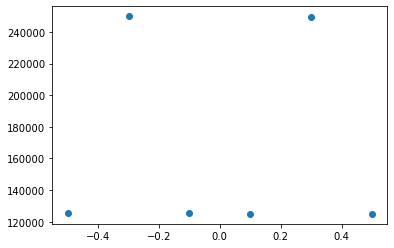

In [244]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(X, Y)
plt.show()

In [118]:
def Get_meas_prob(measurement_array):
    
    N_shots = measurement_array.shape[0]
    
    sum_rows = np.sum(measurement_array, axis=1)%2

    number_ones = sum(sum_rows)
    number_zeros = N_shots - number_ones
    
    exp_dict = {-1: number_ones/N_shots, +1: number_zeros/N_shots}
    
    return exp_dict

In [187]:
XZZ_dict = Get_meas_prob(XZZ_measurements)
XIX_dict = Get_meas_prob(XIX_measurements)
ZZI_dict = Get_meas_prob(ZZI_measurements)

In [290]:
from quchem.Unitary_Partitioning.Seq_Rot_circuit_functions import Full_SeqRot_Rl_Circuit

S_index=2
check_reduction_lin_alg = True
AC_set = anti_commuting_sets[0]

full_circuit, Ps, gamma_l = Full_SeqRot_Rl_Circuit(ansatz_circuit,
                                                   AC_set,
                                                   S_index,
                                                   N_qubits,
                                                   check_reduction_lin_alg=check_reduction_lin_alg)
full_circuit

0: ───I───Rx(0.5π)───@────────────────@───Rx(-0.5π)───Rx(0.5π)───@────────────────────────@───Rx(-0.5π)───M───
                     │                │                          │                        │               │
1: ───H──────────────┼────────────────┼──────────────────────────X───@────────────────@───X───────────────M───
                     │                │                              │                │
2: ───I──────────────X───Rz(-0.25π)───X───H──────────────────────────X───Rz(-0.36π)───X───H───────────────────

In [291]:
Ps

1 [Z0 Z1]

In [292]:
Ps_word, coeff = tuple(*Ps.terms.items())
Ps_QNo, PS_Pstr = zip(*P_word)
Ps_QNo

(0, 1)

In [302]:
final_state = full_circuit.final_state_vector(ignore_terminal_measurements=True)

Ps_measurements = cirq.sim.sample_state_vector(
    state_vector= final_state,
    indices=Ps_QNo,
    repetitions=N_shots
    )
Ps_measurements

array([[1, 0],
       [0, 1],
       [1, 1],
       ...,
       [0, 0],
       [0, 0],
       [0, 1]], dtype=uint8)

In [305]:
parity_results_Ps  = np.sum(Ps_measurements, axis=1)%2

H_exp_UP = [1*gamma_l if res ==0 else -1*gamma_l for res in parity_results_Ps]
result_counted_UP = Counter(H_exp_UP)


results_sorted_UP = sorted(list(result_counted_UP.items()), key= lambda x: x[0])
X_UP, Y_UP = zip(*results_sorted_UP)

In [309]:
Y_UP

(500075, 499925)

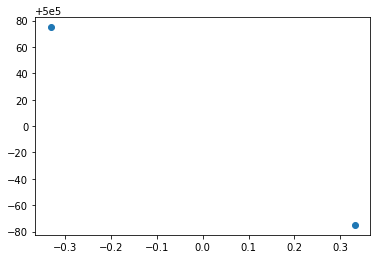

In [310]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(X_UP, Y_UP)
plt.show()

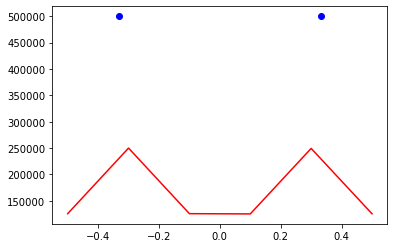

In [311]:
%matplotlib inline

plt.plot()
plt.plot(X, Y, color = 'red')
plt.scatter(X_UP, Y_UP, color = 'blue')
plt.show()

In [312]:
from openfermion import get_sparse_operator

psi = ansatz_circuit.final_state_vector()
rho = np.outer(psi, psi)

H_mat = get_sparse_operator(H).todense()

np.einsum('ij,ij', rho, H_mat)

0j

In [313]:
np.trace(H_mat.dot(rho))

0j

In [317]:
np.mean(H_exp_UP)

-4.974937185533106

In [318]:
np.mean(H_exp_results)

-0.0003118000000000002